## 1. Load the Data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, auc, f1_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None

#### 1.1 Read .csv file into a Dataframe

In [3]:
#read in files - full dataset - no reduced columns 
df = pd.read_csv('data/application_clean.csv')  #application.csv (no column reduction)
df_red = pd.read_csv('data/REDUCED_application_clean.csv') #application dataframs with reduced columns 
df_eng = pd.read_csv('data/application_bureau.csv') #application data combined added features from burea dataframe

#delete "unnamed:0" column from all dataframes
df.drop('Unnamed: 0', axis=1, inplace=True)
df_red.drop('Unnamed: 0', axis=1, inplace=True)
df_eng.drop('Unnamed: 0', axis=1, inplace=True)

print(df.shape)
print(df_red.shape)
print(df_eng.shape)

(307216, 122)
(307216, 53)
(307216, 87)


## 2. Data Preprocessing

#### Functions for preprocessing the data:

In [22]:
def preprocess(df, dtype):
    
    #create dataframe to hold all features that are categories (datatype object)
    dfo=df.select_dtypes(include=['object']) # select object type columns
    ##dfo_test =  df_test.select_dtypes(include=['object'])
    
    #create a dataframe to hold only numeric values - this dataset will be used to impute the mean and scale the data
    df_s = df.drop(dfo, axis=1)
    ##df_s_test = df_test.drop(dfo_test, axis=1)

    #create new dataframe to hold flag columns 
    #if it's complete dataset (dtype==1) hold all flags
    if(dtype==1):
        col = ['FLAG_MOBIL', 'FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE', 'FLAG_PHONE','FLAG_EMAIL',
           'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
           'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
           'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
           'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
           'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16','FLAG_DOCUMENT_17', 
           'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']
    elif(dtype==0):
         col = ['FLAG_MOBIL', 'FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE', 'FLAG_PHONE','FLAG_EMAIL']
            
    flags = df_s[col]

    #drop flag columns from df_s and df_s_ testsince they don't need to be scaled
    df_s = df_s.drop(col, axis=1)

    ID = df_s['SK_ID_CURR']
    ##df_s_test.drop(columns=['SK_ID_CURR'], inplace=True)
    
    #remove 'TARGET' cloumn from dataframe while scaling and imputing in order to avoid data leakage 
    target = df_s['TARGET']
    df_s.drop(columns=['TARGET'], inplace=True)
    
    #store column names so we can use them to convert array to dataframe
    names = df_s.columns
    #names_test = df_s_test.columns
    
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

    scaled = imputer.fit_transform(df_s)
    #scaled_test = imputer.transform(df_s_test)

    df_s = pd.DataFrame(scaled, columns = names)

    
    from sklearn.preprocessing import MinMaxScaler

    # define min max scaler
    scaler = MinMaxScaler()

    # transform data
    scaled = scaler.fit_transform(df_s)
    ##scaled_test = scaler.transform(df_s_test)

    #convert array to dataframe
    df_scaled = pd.DataFrame(scaled, columns=names)
    ##df_scaled_t = pd.DataFrame(scaled_test, columns=names)
    
    df_scaled['SK_ID_CURR'] = ID
    ##df_scaled_t['SK_ID_CURR'] = ID_test
    
    dfo = pd.get_dummies(dfo)
    ##dfo_test = pd.get_dummies(dfo_test)

    ##dfo, dfo_test = dfo.align(dfo_test, join = 'inner', axis = 1)

    df_scaled = pd.concat([df_scaled, dfo], axis=1)
    ##df_scaled_t = pd.concat([df_scaled_t, dfo_test], axis=1)
    
    df_scaled = pd.concat([df_scaled, flags], axis=1)
    #df_scaled_t = pd.concat([df_scaled_t, flags_test], axis=1)
    
    df_scaled['TARGET'] = target
    print('df_scaled SHape - after adding TARGET:')
    print(df_scaled.shape)
    ##print(df_scaled_t.shape)
    print('')
    
    return df_scaled
    

In [5]:
#this function balances the data - currently the data is imbalanced and the target value is 91.9% = 0 (loan paid) and 8.1% =1 (unpaid)
def balance_data(df):
    #under sample imbalanced data - reduce rows with TARGET=0
    from imblearn.under_sampling import RandomUnderSampler

    df_train = df    
    print('TARGET values before undersampling: ')
    print(df_train.TARGET.value_counts())

    X = df_train.drop('TARGET', axis = 1)
    y = df_train['TARGET']

    rus = RandomUnderSampler()
    X_rus, y_rus = rus.fit_resample(X, y)
    
    #from imblearn.combine import SMOTEENN
    #smote_enn = SMOTEENN(random_state=0)
    #X_resampled, y_resampled = smote_enn.fit_resample(X, y)
    #print(sorted(Counter(y_resampled).items()))
    
    #from imblearn.combine import SMOTETomek
    #smote_tomek = SMOTETomek(random_state=0)
    #X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
    #print(sorted(Counter(y_resampled).items()))
    
    return X_rus, y_rus
    #print('Removed indexes:', id_rus)

    #plot_2d_space(X_rus, y_rus, 'Random under-sampling')


### 2.1 Application Data - without column reduction or feature engineering

In [23]:
#call function to preprocess data
df_s = preprocess(df,1)
print(df_s.shape)

#call function to balance data
X_balance, y_balance = balance_data(df_s) 
print('BALANCED: ' + str(X_balance.shape) + ' ' + str(y_balance.shape))

df_scaled SHape - after adding TARGET:
(307216, 244)

(307216, 244)
TARGET values before undersampling: 
0    282412
1     24804
Name: TARGET, dtype: int64
BALANCED: (49608, 243) (49608,)


In [7]:
import statsmodels.api as sm #used for statistical computations: descriptive statistics, estimation and inference
from statsmodels.graphics.api import abline_plot # provides the ability to do regression plots
from sklearn.metrics import mean_squared_error, r2_score # Classification metrics, implements several loss, score, and utility functions to measure classification performance. 
from sklearn import linear_model, preprocessing #LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares
import warnings # For handling error messages.

In [26]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_balance, y_balance, test_size=0.3, random_state=123)

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(log_reg.score(X_test, y_test)))


print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      7328
           1       0.00      0.00      0.00      7555

    accuracy                           0.49     14883
   macro avg       0.25      0.50      0.33     14883
weighted avg       0.24      0.49      0.32     14883



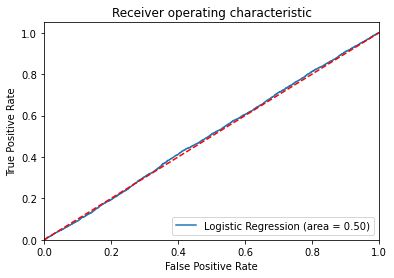

In [46]:

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, log_reg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### GRADIENT BOOST - 122 features

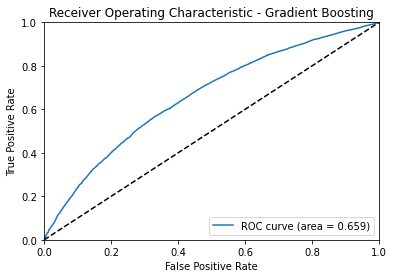

Accuracy score (training): 0.623
Accuracy score (validation): 0.614
Accuracy: 0.614


In [47]:
ac_train, ac_val, accuracy = GB_model(X_balance, y_balance)
#print('Classification Report: ')
#print(classification_report)


print("Accuracy score (training): {0:.3f}".format(ac_train))
print("Accuracy score (validation): {0:.3f}".format(ac_val))
print("Accuracy: {}".format(accuracy))

#### Random Forest

Training Shape: (34725, 243)
Testing Shape: (14883, 243)
Random Forest: Accuracy=0.682
Random Forest: f1-score=0.682
30


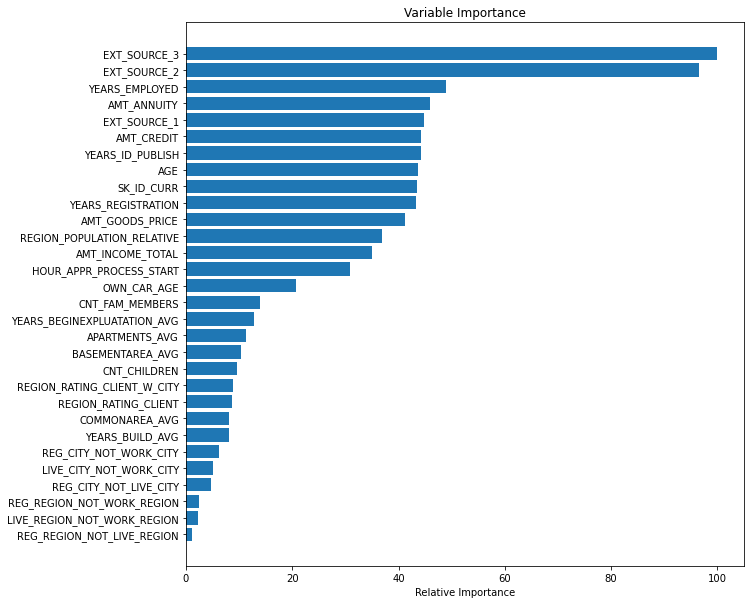

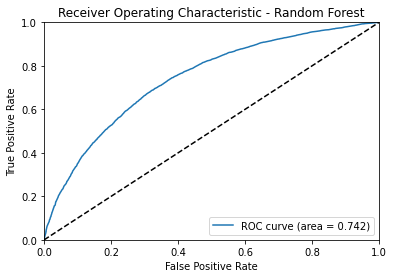

In [51]:
RF_model(X_balance, y_balance)

### 2.2 Modeling with reduced columns

In [52]:
#call function to preprocess data
df_processed = preprocess(df_red, 0)
print(df_processed.shape)

#call function to balance data
X, y = balance_data(df_processed) 
print('BALANCED: ' + str(X.shape) + ' ' + str(y.shape))

df_scaled SHape - after adding TARGET:
(307216, 163)

(307216, 163)
TARGET values before undersampling: 
0    282412
1     24804
Name: TARGET, dtype: int64
BALANCED: (49608, 162) (49608,)


#### Logistic Regression

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Make the model with the specified regularization parameter
log_reg2 = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg2.fit(X_train, y_train)

y_pred = log_reg2.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(log_reg2.score(X_test, y_test)))


print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      7328
           1       0.00      0.00      0.00      7555

    accuracy                           0.49     14883
   macro avg       0.25      0.50      0.33     14883
weighted avg       0.24      0.49      0.32     14883



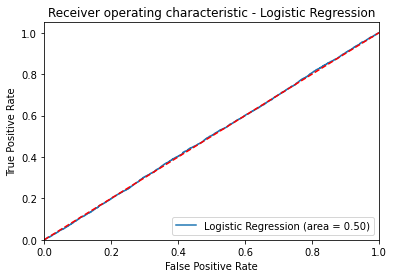

In [56]:
logit_roc_auc = roc_auc_score(y_test, log_reg2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, log_reg2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Gradient Boost

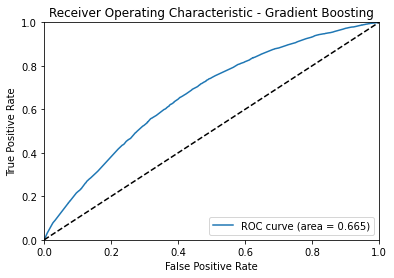

Accuracy score (training): 0.629
Accuracy score (validation): 0.623
Accuracy: 0.623


In [58]:
ac_train, ac_val, accuracy = GB_model(X, y)
#print('Classification Report: ')
#print(classification_report)


print("Accuracy score (training): {0:.3f}".format(ac_train))
print("Accuracy score (validation): {0:.3f}".format(ac_val))
print("Accuracy: {}".format(accuracy))

#### Random Forest

Training Shape: (34725, 162)
Testing Shape: (14883, 162)
Random Forest: Accuracy=0.682
Random Forest: f1-score=0.682
30


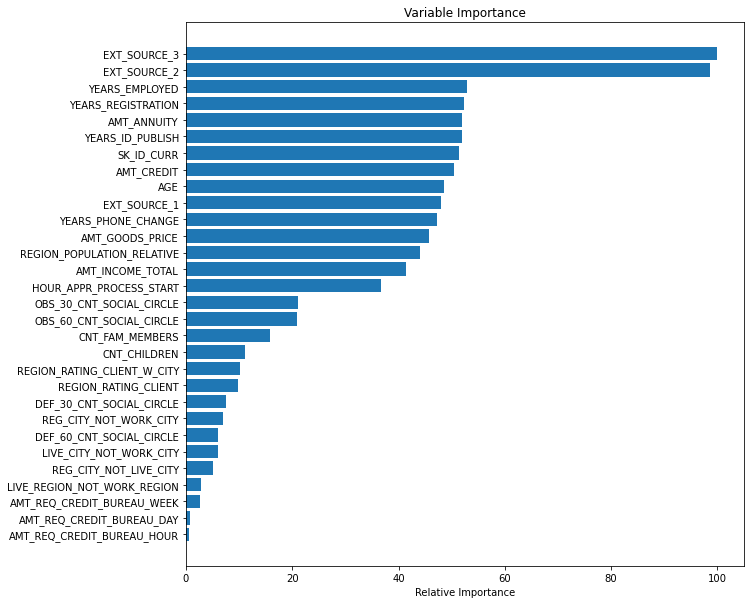

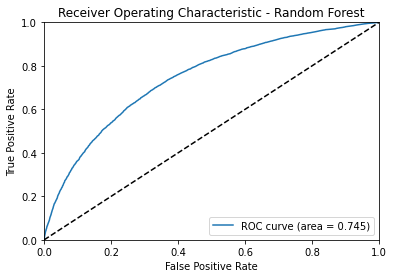

In [59]:
RF_model(X, y)

## Random Forest Classifier

In [50]:
def RF_model(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    print("Training Shape: " + str(X_train.shape))
    print("Testing Shape: " + str(X_test.shape))
    random_forest = RandomForestClassifier(n_estimators=1000, random_state=1, n_jobs=-1)
    model = random_forest.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    lr_probs = y_pred_prob[:,1]
    #ac = accuracy_score(y_test, y_pred)
    ac = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print('Random Forest: Accuracy=%.3f' % (ac))
    print('Random Forest: f1-score=%.3f' % (f1))
    
    feature_importance = random_forest.feature_importances_

    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
    sorted_idx = np.argsort(feature_importance)[:30]

    pos = np.arange(sorted_idx.shape[0]) + .5
    print(pos.size)
    sorted_idx.size
    plt.figure(figsize=(10,10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    y_true = y_test # ground truth labels
    y_probas = model.predict_proba(X_test)  # predicted probabilities generated by sklearn classifier
    probs = y_probas[:,1]
    # Calculate fpr, tpr, thresholds and roc_auc
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Random Forest')
    plt.legend(loc="lower right")
    plt.show()

## Gardient Boosting Classifier

In [34]:
def best_params(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    
    gb = GradientBoostingClassifier()
    parameters = {
    "n_estimators":[5,50,100],
    "max_depth":[3,5,7],
    "learning_rate":[1,10,50]
    }
    
    from sklearn.model_selection import GridSearchCV
    cv = GridSearchCV(gb,parameters,cv=5)
    cv.fit(X_train, y_train.values.ravel())
    
    print(cv.best_params_)
   
    #learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
    #for learning_rate in learning_rates:
     #   gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
      #  gb.fit(X_train, y_train)
       # print("Learning rate: ", learning_rate)
        #print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
        #print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
        #print()


In [45]:
def GB_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    gb_model = GradientBoostingClassifier(n_estimators=5, learning_rate=1, max_features=5, max_depth=3, random_state=0)
    gb_model.fit(X_train, y_train)

    y_pred = gb_model.predict(X_test)

    # Compute confusion matrix
   # cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    #print('Confusion Matrix')
    ac_train = gb_model.score(X_train, y_train)
    ac_val = gb_model.score(X_test, y_test)
    accuracy = round((y_pred==y_test).sum()/len(y_pred),3)
    
    y_true = y_test # ground truth labels
    y_probas = gb_model.predict_proba(X_test)  # predicted probabilities generated by sklearn classifier
    probs = y_probas[:,1]
    # Calculate fpr, tpr, thresholds and roc_auc
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Gradient Boosting')
    plt.legend(loc="lower right")
    plt.show()
    return( ac_train, ac_val, accuracy)

    

   # print(classification_report(y_pred, y_test))

    #print("Accuracy score (training): {0:.3f}".format(gb_model.score(X_train, y_train)))
    #print("Accuracy score (validation): {0:.3f}".format(gb_model.score(X_test, y_test)))
    #print("Accuracy: {}".format(round((y_pred==y_test).sum()/len(y_pred),3)))